In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [3]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 100.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 0.7
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])
model.run()
te = model.exc[0,-1]
ti = model.inh[0,-1]

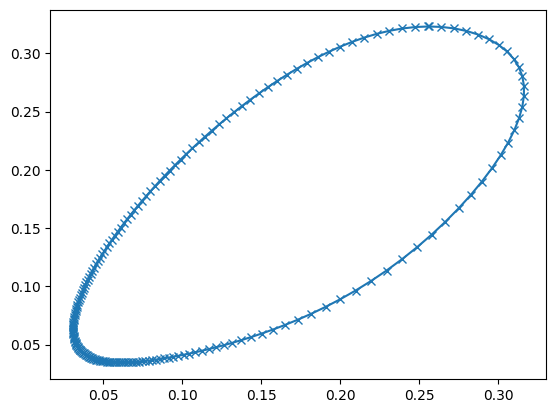

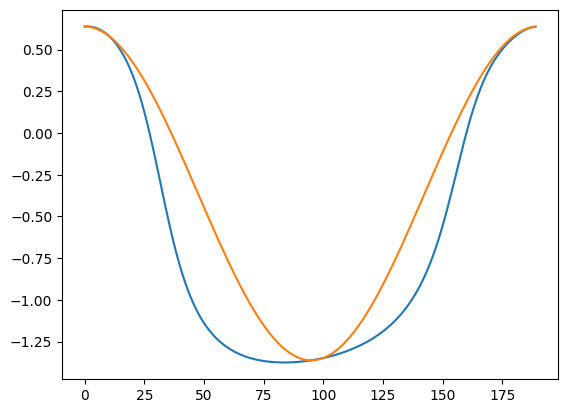

84 95


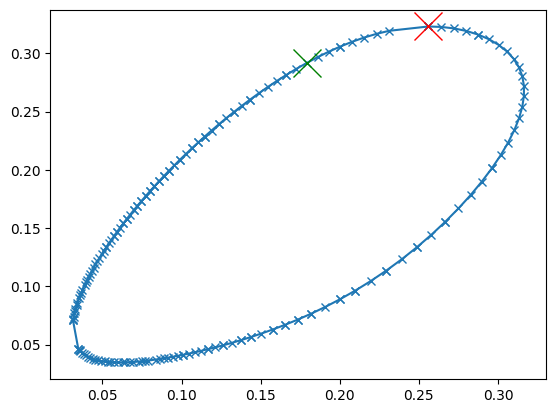

In [4]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 100.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 1.
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])
model.run()

state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

peaks = scipy.signal.find_peaks(model.exc[0,-500:])[0]
period = dt * (peaks[-1] - peaks[-2])

#plot_oc_singlenode(duration, dt, state, target, control)

dur_array = np.arange(duration, duration+period, dt)
init_ellipse = np.zeros((1,4,len(dur_array)))
init_phase = np.zeros((1, len(dur_array)))
for t in range(len(dur_array)):
    d = dur_array[t]
    model.params.duration = d
    model.run()
    hilb = scipy.signal.hilbert(model.exc[0,:])[-1]
    init_phase[0,t] = np.arctan2(hilb.imag, hilb.real)

    init_ellipse[0,0,t] = model.exc[0,-1]
    init_ellipse[0,1,t] = model.inh[0,-1]

plt.plot(init_ellipse[0,0,:], init_ellipse[0,1,:], marker='x')
plt.show()

phase_mapped = np.cos(2.*np.pi*np.arange(0,len(dur_array),1)/len(dur_array))-(1.-init_phase[0,0])

plt.plot(np.arange(0,len(dur_array),1), init_phase[0,:])
plt.plot(np.arange(0,len(dur_array),1), phase_mapped)
plt.show()

init_ellipse_mapped = np.zeros((init_ellipse.shape))
init_ellipse_mapped[0,:,0] = init_ellipse[0,:,0]

t_break_init = init_phase[0,:].argmin()
t_break_mapped = phase_mapped.argmin()
print(t_break_init, t_break_mapped)

ics = []

for t in range(t_break_mapped):
    idx = (np.abs(init_phase[0,:t_break_init]-phase_mapped[t])).argmin()
    ics.append(idx)

for t in range(t_break_mapped, 2*t_break_mapped,1):
    idx = (np.abs(init_phase[0,t_break_init:]-phase_mapped[t])).argmin()
    ics.append(idx + t_break_init)


ellipse_mapped = np.zeros(( init_ellipse[:,:,:len(ics)].shape ))
for t in range(len(ics)):
    idx = ics[t]
    ellipse_mapped[0,:,t] = init_ellipse[0,:,idx]

plt.plot(ellipse_mapped[0,0,:], ellipse_mapped[0,1,:], marker='x')
plt.plot(ellipse_mapped[0,0,0], ellipse_mapped[0,1,0], color='red', markersize=20,marker='x')
plt.plot(ellipse_mapped[0,0,10], ellipse_mapped[0,1,10], color='green', markersize=20,marker='x')
plt.show()

duration = 250.
model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 1.

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])

model.run()

target_osc = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

target_down = np.zeros((target_osc.shape))
target_down[0,0,:] = te
target_down[0,1,:] = ti

In [5]:
def plot_random_init(time, s, t, c, filename):

    fig, ax = plt.subplots(2,1)

    for m in range(0, len(s), 20):
        ax[0].plot(time, s[m][0,0,1:])

    ax[0].plot(time, t[0,0,1:], linestyle='--', color='red')
    ax[0].set_xlim(0,duration)
    ax[0].set_ylabel("Excitatory activity")

    ax[1].plot(time, c[0,0,1:], color='red')
    ax[1].plot(time, c[0,1,1:], color='blue')
    ax[1].set_xlim(0,duration)
    ax[1].set_ylabel("Control")

    plt.savefig(filename)
    plt.show()

Compute control for a noisy system
Mean cost in iteration 0: 0.661181568740629
Mean cost in iteration 25: 0.021562223794010987
Mean cost in iteration 50: 0.021146595481036205
Mean cost in iteration 75: 0.02132622257971907
Mean cost in iteration 100: 0.02141539465923119
Minimal cost found at iteration 36
Final cost validated with 400 noise realizations : 0.02107492208900728


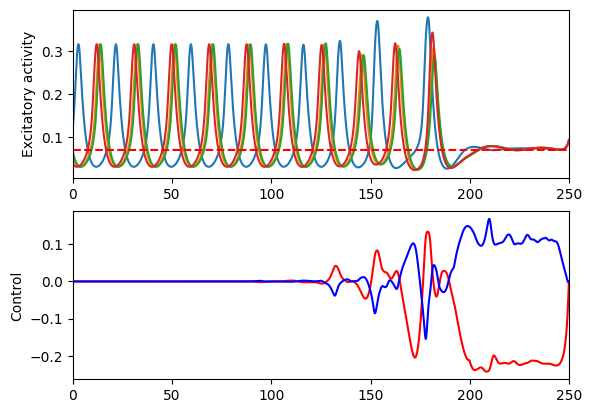

In [22]:
w2=1e-2
M_ = 80

model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.optimize(100)
states = model_controlled.M_states
control = model_controlled.control

fname = "osc_down_w2_-2.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

w2=1e-1
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.optimize(100)
states = model_controlled.M_states
control = model_controlled.control

fname = "osc_down_w2_-1.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

Compute control for a noisy system
Mean cost in iteration 0: 0.6546390209674122
Mean cost in iteration 25: 0.10867827319608506
Mean cost in iteration 50: 0.0907530809332556
Mean cost in iteration 75: 0.07288783915100754
Mean cost in iteration 100: 0.056358632879935366
Mean cost in iteration 125: 0.04736812728102355
Mean cost in iteration 150: 0.04031813441001515
Mean cost in iteration 175: 0.03662494152533364
Mean cost in iteration 200: 0.03414372972979851
Mean cost in iteration 225: 0.03114858480554116
Mean cost in iteration 250: 0.028427981691502336
Mean cost in iteration 275: 0.027290582339949347
Mean cost in iteration 300: 0.026226072319892442
Mean cost in iteration 325: 0.02530519401170452
Mean cost in iteration 350: 0.024444244251828076
Mean cost in iteration 375: 0.02414437003856394
Mean cost in iteration 400: 0.023496967243483855
Mean cost in iteration 425: 0.023099347219056217
Mean cost in iteration 450: 0.022901243932242417
Mean cost in iteration 475: 0.02270446294544596
Mean

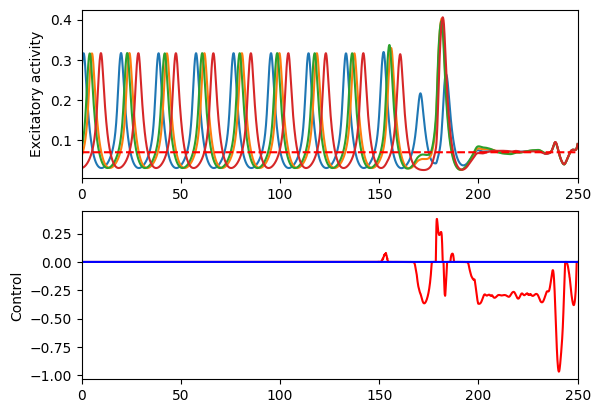

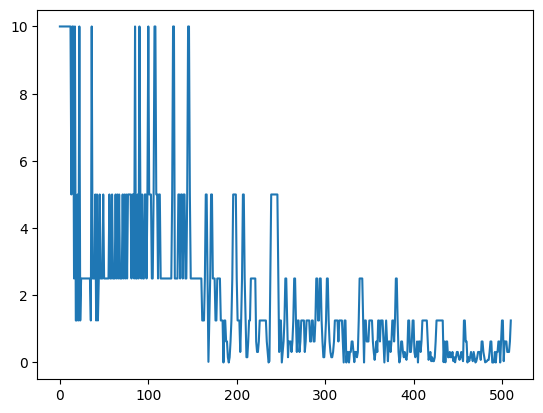

Compute control for a noisy system
Mean cost in iteration 0: 0.6457592132070832
Mean cost in iteration 25: 0.23979651277253522
Mean cost in iteration 50: 0.20550474463456841
Mean cost in iteration 75: 0.19220713855740526
Mean cost in iteration 100: 0.1843398091695882
Mean cost in iteration 125: 0.18031582733143078
Mean cost in iteration 150: 0.1752665080894484
Mean cost in iteration 175: 0.17091465271441467
Mean cost in iteration 200: 0.16985612484412854
Mean cost in iteration 225: 0.16800176190244565
Mean cost in iteration 250: 0.1659770877938312
Mean cost in iteration 275: 0.16586302777200956
Mean cost in iteration 300: 0.1647147947487869
Mean cost in iteration 325: 0.16307200078947945
Mean cost in iteration 350: 0.16311245930187498
Mean cost in iteration 375: 0.1619948224341776
Mean cost in iteration 400: 0.16214099549530508
Mean cost in iteration 425: 0.16007421759946833
Mean cost in iteration 450: 0.16212758606106306
Mean cost in iteration 475: 0.15937868425089835
Mean cost in ite

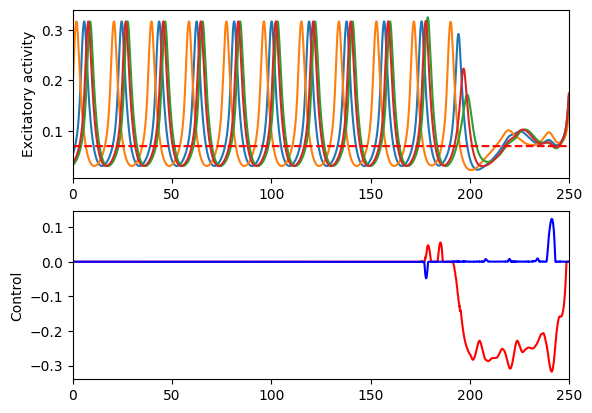

In [62]:
w1=1e-3
M_ = 80

c_mat = np.zeros((1,2))
c_mat[0,0] = 1.
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2 = 0., w_1=w1, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), control_matrix = c_mat, M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(500)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1_-3.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

plt.plot(model_controlled.step_sizes_history)
plt.show()

w1=1e-2
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(500)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1_-2.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

Compute control for a noisy system
Mean cost in iteration 0: 0.6488814826769395
Mean cost in iteration 25: 0.1403048623988244
Mean cost in iteration 50: 0.07854001136997603
Mean cost in iteration 75: 0.040492734680837826
Mean cost in iteration 100: 0.027135614613763858
Mean cost in iteration 125: 0.025162630861499734
Mean cost in iteration 150: 0.02459786672208466
Mean cost in iteration 175: 0.024044419970642113
Mean cost in iteration 200: 0.023745103894028764
Mean cost in iteration 225: 0.02368388961147729
Mean cost in iteration 250: 0.02370218614120573
Mean cost in iteration 275: 0.02375565070598277
Mean cost in iteration 300: 0.023842853101067915
Mean cost in iteration 325: 0.023847864919862787
Mean cost in iteration 350: 0.023898952645989326
Mean cost in iteration 375: 0.02385942643758322
Mean cost in iteration 400: 0.02395079207317274
Mean cost in iteration 425: 0.02392167863160926
Mean cost in iteration 450: 0.02394688302860461
Mean cost in iteration 475: 0.02394253606062883
Mean

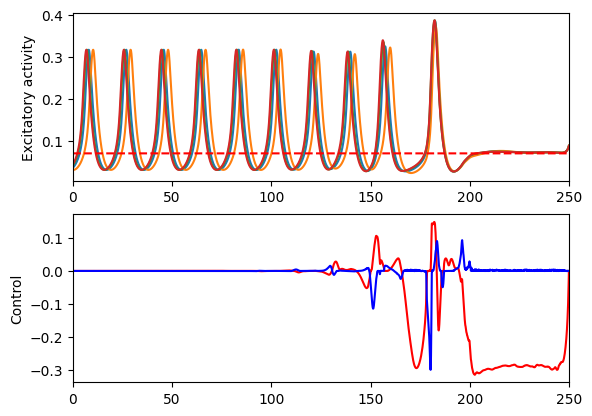

Compute control for a noisy system
Mean cost in iteration 0: 0.6441686248982903
Mean cost in iteration 25: 0.20586510048256654
Mean cost in iteration 50: 0.20623149122999948
Mean cost in iteration 75: 0.20506684738901826
Mean cost in iteration 100: 0.2049915658640998
Mean cost in iteration 125: 0.2042958481019997
Mean cost in iteration 150: 0.20497319710435424
Mean cost in iteration 175: 0.20525233831878106
Mean cost in iteration 200: 0.20472649342890126
Mean cost in iteration 225: 0.20574637758152153
Mean cost in iteration 250: 0.2055094062191932
Mean cost in iteration 275: 0.20529335107421312
Mean cost in iteration 300: 0.20597337297322035
Mean cost in iteration 325: 0.2051888260200196
Mean cost in iteration 350: 0.2048022909308052
Mean cost in iteration 375: 0.20551101207831093
Mean cost in iteration 400: 0.20613277454934348
Mean cost in iteration 425: 0.20645414640014242
Mean cost in iteration 450: 0.20621693528805413
Mean cost in iteration 475: 0.20588827602999965
Mean cost in ite

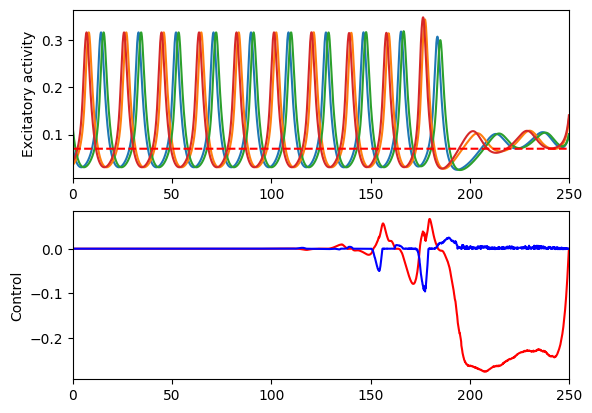

In [63]:
w1T=1e-2
M_ = 80
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2 = 0., w_1T=w1T, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(600)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1T_-2.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

w1T=1e-1
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=0., w_1T=w1T, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(600)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1T_-1.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

Compute control for a noisy system
Mean cost in iteration 0: 0.6368116304197302
Mean cost in iteration 25: 0.22149006924044318
Mean cost in iteration 50: 0.16495401885414235
Mean cost in iteration 75: 0.15172000153910953
Mean cost in iteration 100: 0.14527689897454354
Mean cost in iteration 125: 0.140139375657944
Mean cost in iteration 150: 0.1346495295729862
Mean cost in iteration 175: 0.1314821883731086
Mean cost in iteration 200: 0.1280543240968986
Mean cost in iteration 225: 0.12528074755033453
Mean cost in iteration 250: 0.12246759244589005
Mean cost in iteration 275: 0.11969088598159272
Mean cost in iteration 300: 0.115930488846964
Mean cost in iteration 325: 0.1120175337920311
Mean cost in iteration 350: 0.10841900139595248
Mean cost in iteration 375: 0.10542293354767458
Mean cost in iteration 400: 0.10214898372084176
Mean cost in iteration 425: 0.0988330822306727
Mean cost in iteration 450: 0.09538610855704806
Mean cost in iteration 475: 0.09190665953078578
Mean cost in iterati

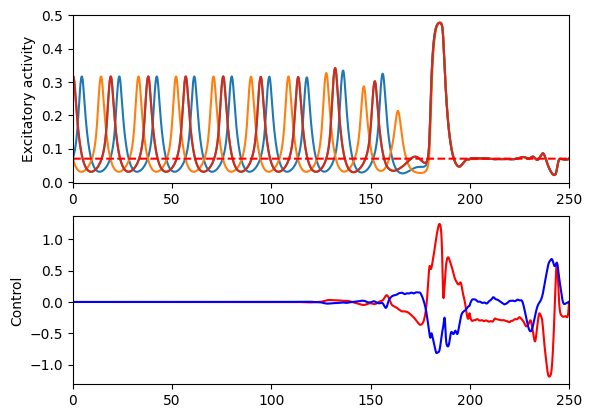

Compute control for a noisy system
Mean cost in iteration 0: 0.6279901829814697
Mean cost in iteration 25: 0.2476221296563667
Mean cost in iteration 50: 0.23376251679932353
Mean cost in iteration 75: 0.22849681579648262
Mean cost in iteration 100: 0.22736048901220768
Mean cost in iteration 125: 0.22790664703664737
Mean cost in iteration 150: 0.2279779633511224
Mean cost in iteration 175: 0.22813314599077397
Mean cost in iteration 200: 0.2282400512924815
Mean cost in iteration 225: 0.22833966159092195
Mean cost in iteration 250: 0.22842694339895142
Mean cost in iteration 275: 0.22842762972868402
Mean cost in iteration 300: 0.22858034311353928
Mean cost in iteration 325: 0.22862240409874923
Mean cost in iteration 350: 0.22873446881495493
Mean cost in iteration 375: 0.22867858120067092
Mean cost in iteration 400: 0.2288043323947672
Mean cost in iteration 425: 0.2290013237176475
Mean cost in iteration 450: 0.22883436981711677
Mean cost in iteration 475: 0.22895724992063776
Mean cost in ite

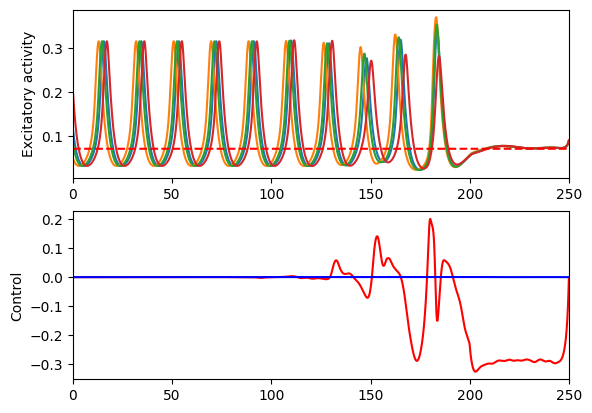

In [64]:
w1D=1e-2
M_ = 80
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2 = 0., w_1D=w1D, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(600)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1D_-2.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

w1D=1e-1
model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2 = 0., w_1D=w1D, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=400, random_init=init_ellipse)
model_controlled.step = 1e1
model_controlled.optimize(600)

states = model_controlled.M_states
control = model_controlled.control
fname = "osc_down_w1D_-1.png"
plot_random_init(model_controlled.model.t, states, target_down, control, fname)

----------------- 175.0
Compute control for a noisy system
Mean cost in iteration 0: 1.2745189166367823
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.2340582364302397
osc_phase_w2_-2_175


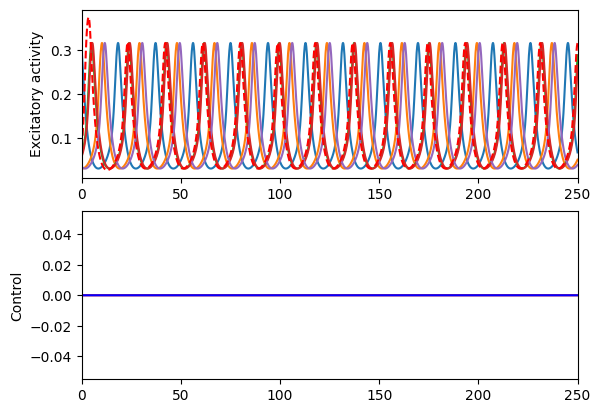

----------------- 180.0
Compute control for a noisy system
Mean cost in iteration 0: 1.1848559925151763
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.1696218709884285
osc_phase_w2_-2_180


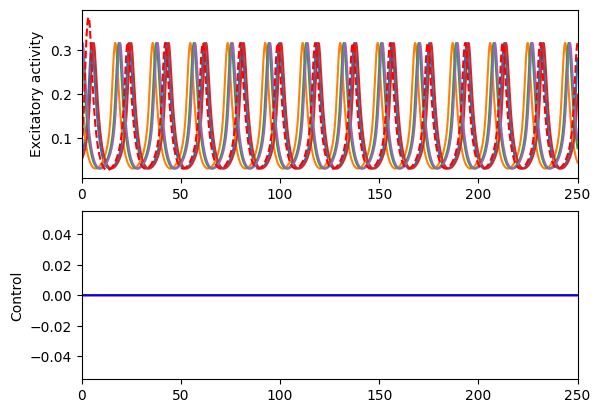

----------------- 185.0
Compute control for a noisy system
Mean cost in iteration 0: 1.064766606241508
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.1195360762118503
osc_phase_w2_-2_185


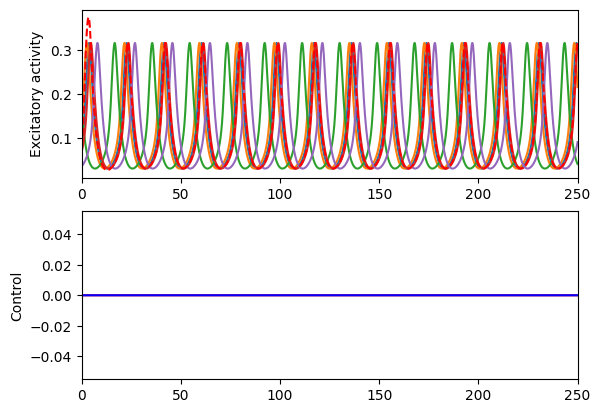

----------------- 190.0
Compute control for a noisy system
Mean cost in iteration 0: 1.0866147018214365
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.023851395599552
osc_phase_w2_-2_190


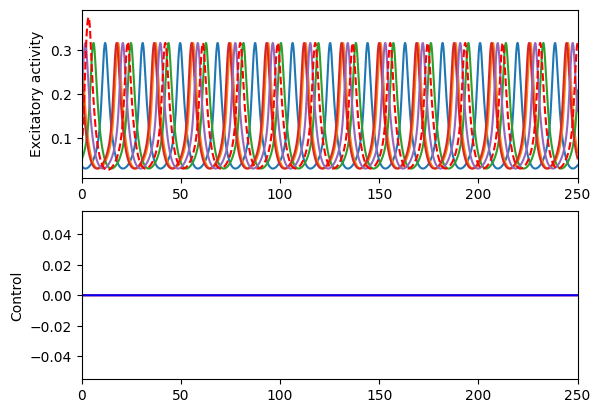

----------------- 195.0
Compute control for a noisy system
Mean cost in iteration 0: 0.8523952620911673
Minimal cost found at iteration 0


KeyboardInterrupt: 

In [78]:
w2=1e-2
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w2_-2_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, fname)

----------------- 175.0
Compute control for a noisy system
Mean cost in iteration 0: 1.2564470626278355
Mean cost in iteration 25: 0.20539341976681152
Mean cost in iteration 50: 0.12622074461558697
Mean cost in iteration 75: 0.11809029080348625
Mean cost in iteration 100: 0.10767197739922925
Mean cost in iteration 125: 0.0960901272723155
Mean cost in iteration 150: 0.09225230098041769
Mean cost in iteration 175: 0.09055083795873953
Mean cost in iteration 200: 0.08844494565755838
Mean cost in iteration 225: 0.08495170079012482
Mean cost in iteration 250: 0.08148613889686505
Mean cost in iteration 275: 0.07885995858872516
Mean cost in iteration 300: 0.07468005623240306
Mean cost in iteration 325: 0.07121973257091199
Mean cost in iteration 350: 0.07330143076491548
Mean cost in iteration 375: 0.06931273629171081
Mean cost in iteration 400: 0.069514195339568
Mean cost in iteration 425: 0.06724684244879311
Mean cost in iteration 450: 0.06441328337983036
Mean cost in iteration 475: 0.06851377

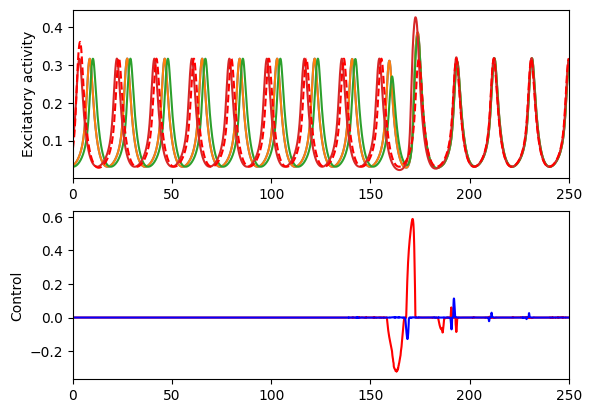

----------------- 180.0
Compute control for a noisy system
Mean cost in iteration 0: 1.1321221544433848
Mean cost in iteration 25: 0.1312368778055659
Mean cost in iteration 50: 0.12260072151443169
Mean cost in iteration 75: 0.12094827930136043
Mean cost in iteration 100: 0.11988172557757415
Mean cost in iteration 125: 0.11841167699297055
Mean cost in iteration 150: 0.11713760141045611
Mean cost in iteration 175: 0.11517941936704953
Mean cost in iteration 200: 0.11435546578797084
Mean cost in iteration 225: 0.11368378509705523
Mean cost in iteration 250: 0.11285469461012809
Mean cost in iteration 275: 0.11208832401752493
Mean cost in iteration 300: 0.10880280788969285
Mean cost in iteration 325: 0.10811915219265511
Mean cost in iteration 350: 0.10759987118570806
Mean cost in iteration 375: 0.10619356279753103
Mean cost in iteration 400: 0.10623127966115756
Mean cost in iteration 425: 0.10558757790728454
Mean cost in iteration 450: 0.10356443093739816
Mean cost in iteration 475: 0.103048

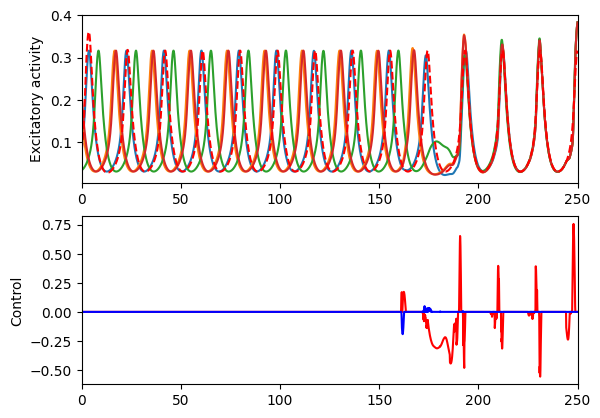

----------------- 185.0
Compute control for a noisy system
Mean cost in iteration 0: 0.9578921592189735
Mean cost in iteration 25: 0.2787726393130373
Mean cost in iteration 50: 0.16876954815905648
Mean cost in iteration 75: 0.15138266955898005
Mean cost in iteration 100: 0.1441892585824425
Mean cost in iteration 125: 0.1415260151648846
Mean cost in iteration 150: 0.13311245994167914
Mean cost in iteration 175: 0.12124317496067374
Mean cost in iteration 200: 0.11394679164474866
Mean cost in iteration 225: 0.10898782449854016
Mean cost in iteration 250: 0.10874523115897723
Mean cost in iteration 275: 0.10440672418584432
Mean cost in iteration 300: 0.10243395682654595
Mean cost in iteration 325: 0.09870745111903179
Mean cost in iteration 350: 0.09613687727959334
Mean cost in iteration 375: 0.09515806953973817
Mean cost in iteration 400: 0.09264625247318448
Mean cost in iteration 425: 0.09089642428085976
Mean cost in iteration 450: 0.08829636054691517
Mean cost in iteration 475: 0.08816620

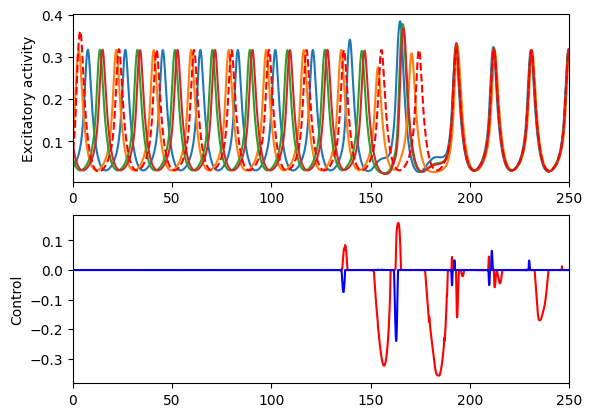

----------------- 190.0
Compute control for a noisy system
Mean cost in iteration 0: 1.074177553322538
Mean cost in iteration 25: 0.2735102999768383
Mean cost in iteration 50: 0.16111225847130145
Mean cost in iteration 75: 0.1493335308977855
Mean cost in iteration 100: 0.14535722125478573
Mean cost in iteration 125: 0.1407634291370362
Mean cost in iteration 150: 0.13630711798923453
Mean cost in iteration 175: 0.1318008705626725
Mean cost in iteration 200: 0.12934414247424292
Mean cost in iteration 225: 0.12509865687417837
Mean cost in iteration 250: 0.12008246766535154
Mean cost in iteration 275: 0.11755705018100049
Mean cost in iteration 300: 0.11554965185589094
Mean cost in iteration 325: 0.11189556974877653
Mean cost in iteration 350: 0.10889810967264764
Mean cost in iteration 375: 0.10540461696357328
Mean cost in iteration 400: 0.10201799931542337
Mean cost in iteration 425: 0.09879340036140202
Mean cost in iteration 450: 0.09753819450080009
Mean cost in iteration 475: 0.0941350998

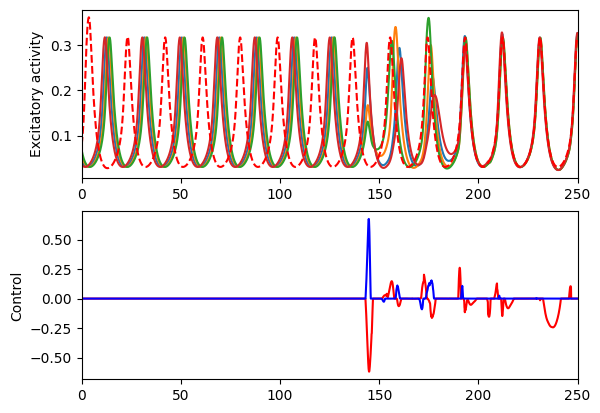

----------------- 195.0
Compute control for a noisy system
Mean cost in iteration 0: 0.7480036313570511
Mean cost in iteration 25: 0.12490507810234926
Mean cost in iteration 50: 0.11114351082125706
Mean cost in iteration 75: 0.10609565259697147
Mean cost in iteration 100: 0.10177613290162471
Mean cost in iteration 125: 0.0966015342544216
Mean cost in iteration 150: 0.08928906413931828
Mean cost in iteration 175: 0.08589850627194232
Mean cost in iteration 200: 0.07742567623123361
Mean cost in iteration 225: 0.0797413947887058
Mean cost in iteration 250: 0.07297763547473915
Mean cost in iteration 275: 0.06940965520959895
Mean cost in iteration 300: 0.0661625648119892
Mean cost in iteration 325: 0.06620106503046436
Mean cost in iteration 350: 0.06931353091973151
Mean cost in iteration 375: 0.06277185601798371
Mean cost in iteration 400: 0.061155738630066306
Mean cost in iteration 425: 0.06359958370071588
Mean cost in iteration 450: 0.06181910288442708
Mean cost in iteration 475: 0.0588864

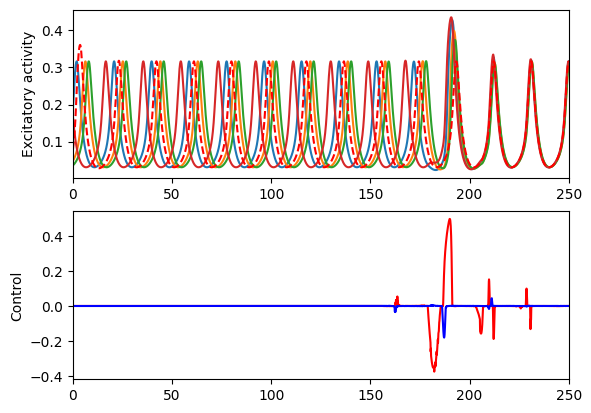

----------------- 200.0
Compute control for a noisy system
Mean cost in iteration 0: 0.7714532483182716
Mean cost in iteration 25: 0.11051388052457996
Mean cost in iteration 50: 0.10428407185806299
Mean cost in iteration 75: 0.09687864724903184
Mean cost in iteration 100: 0.08816981553857316
Mean cost in iteration 125: 0.08374955463817674
Mean cost in iteration 150: 0.08098196436442265
Mean cost in iteration 175: 0.0782954316464536
Mean cost in iteration 200: 0.07772814797873481
Mean cost in iteration 225: 0.07538931492651398
Mean cost in iteration 250: 0.07369918032798936
Mean cost in iteration 275: 0.07304669039611679
Mean cost in iteration 300: 0.07311180705846673
Mean cost in iteration 325: 0.07195703469502748
Mean cost in iteration 350: 0.0706809868306463
Mean cost in iteration 375: 0.06966928351170684
Mean cost in iteration 400: 0.06879024867605807
Mean cost in iteration 425: 0.06896485410706762
Mean cost in iteration 450: 0.06922695839142881
Mean cost in iteration 475: 0.0683788

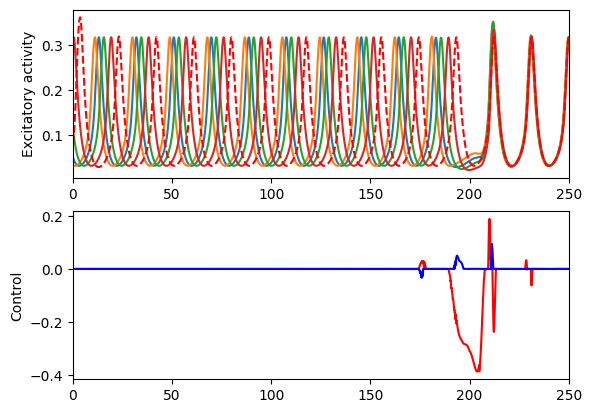

In [6]:
w1=1e-2
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w1_-2_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, fname)

----------------- 175.0
Compute control for a noisy system
Mean cost in iteration 0: 1.2998549602865181
Mean cost in iteration 25: 1.3155669681054034
Mean cost in iteration 50: 1.2383774183628222
Mean cost in iteration 75: 1.2423113017407283
Mean cost in iteration 100: 1.1578301494024603
Mean cost in iteration 125: 1.0943933355156754
Mean cost in iteration 150: 1.167202670381696
Mean cost in iteration 175: 1.012366997383602
Mean cost in iteration 200: 0.9392668772746406
Mean cost in iteration 225: 0.8630494226822132
Mean cost in iteration 250: 0.8793490681054885
Mean cost in iteration 275: 0.7624989417725385
Mean cost in iteration 300: 0.7781076454731142
Mean cost in iteration 325: 0.7305394873419144
Mean cost in iteration 350: 0.7596120685884725
Mean cost in iteration 375: 0.6557450059872129
Mean cost in iteration 400: 0.6903591857169398
Mean cost in iteration 425: 0.6264583303826762
Mean cost in iteration 450: 0.6417619122851919
Mean cost in iteration 475: 0.6835839395374437
Mean cos

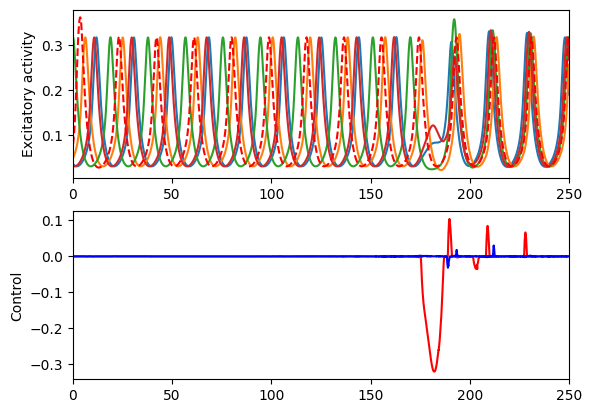

----------------- 180.0
Compute control for a noisy system
Mean cost in iteration 0: 1.1972872875994254
Mean cost in iteration 25: 1.0974988742233358
Mean cost in iteration 50: 1.2760598104572556
Mean cost in iteration 75: 1.2916888812435352
Mean cost in iteration 100: 1.0321105914995057
Mean cost in iteration 125: 1.00539553588567
Mean cost in iteration 150: 0.8173359223545204
Mean cost in iteration 175: 0.7993316898913416
Mean cost in iteration 200: 0.7368157791609843
Mean cost in iteration 225: 0.6619118039027365
Mean cost in iteration 250: 0.7005273958437999
Mean cost in iteration 275: 0.6098484271179873
Mean cost in iteration 300: 0.6582042807519891
Mean cost in iteration 325: 0.6046816638981488
Mean cost in iteration 350: 0.6426708392772629
Mean cost in iteration 375: 0.563276202378304
Mean cost in iteration 400: 0.5874229826432988
Mean cost in iteration 425: 0.5747725151626066
Mean cost in iteration 450: 0.5419236825749703
Mean cost in iteration 475: 0.5415785015815942
Mean cost

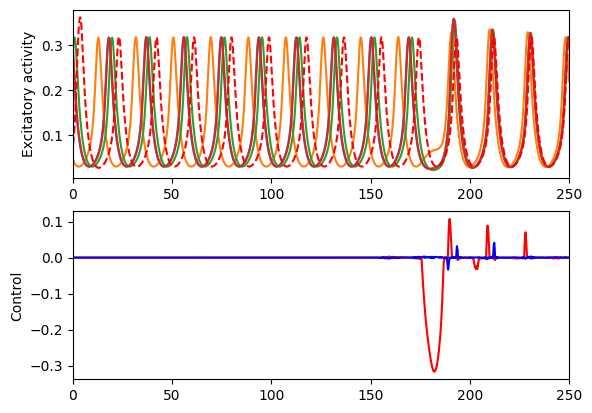

----------------- 185.0
Compute control for a noisy system
Mean cost in iteration 0: 1.1065060903693775
Mean cost in iteration 25: 1.2274011395431779
Mean cost in iteration 50: 1.145260283690775
Mean cost in iteration 75: 1.2316748873704442
Mean cost in iteration 100: 1.2926617083166385
Mean cost in iteration 125: 0.9847149685706895
Mean cost in iteration 150: 1.1029952238966467
Mean cost in iteration 175: 1.0156784764649092
Mean cost in iteration 200: 0.9067666247187276
Mean cost in iteration 225: 0.8420805794967825
Mean cost in iteration 250: 0.8719916609588202
Mean cost in iteration 275: 0.8765761927729919
Mean cost in iteration 300: 0.8835641645859745
Mean cost in iteration 325: 0.7872456791890113
Mean cost in iteration 350: 0.8555301345152904
Mean cost in iteration 375: 0.7881939182420167
Mean cost in iteration 400: 0.8655305514623164
Mean cost in iteration 425: 0.9407501132798469
Mean cost in iteration 450: 0.7428333951828232
Mean cost in iteration 475: 0.822990152032132
Mean cos

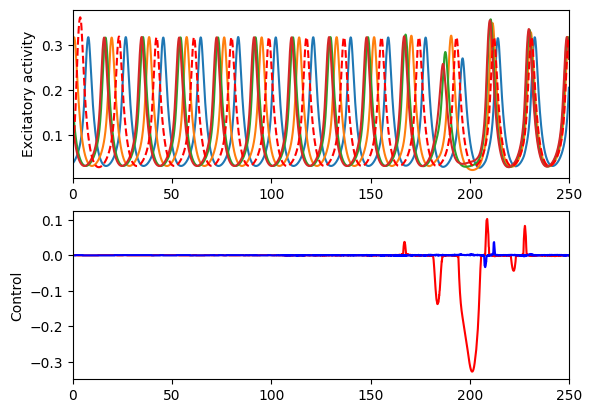

----------------- 190.0
Compute control for a noisy system
Mean cost in iteration 0: 1.0151138264266275
Mean cost in iteration 25: 1.0252015138075643
Mean cost in iteration 50: 1.129917493159399
Mean cost in iteration 75: 1.000896362003286
Mean cost in iteration 100: 1.041752974403955
Mean cost in iteration 125: 0.9192812615344084
Mean cost in iteration 150: 0.9874994820050047
Mean cost in iteration 175: 0.9355209252155735
Mean cost in iteration 200: 0.8649220481892694
Mean cost in iteration 225: 0.9009691813228556
Mean cost in iteration 250: 0.7448361261388425
Mean cost in iteration 275: 0.7349803624847031
Mean cost in iteration 300: 0.7533652856786807
Mean cost in iteration 325: 0.7313976816141341
Mean cost in iteration 350: 0.7932272003262433
Mean cost in iteration 375: 0.688433329127641
Mean cost in iteration 400: 0.6476519319044531
Mean cost in iteration 425: 0.7517098826895198
Mean cost in iteration 450: 0.6594365978615362
Mean cost in iteration 475: 0.6600222110609089
Mean cost 

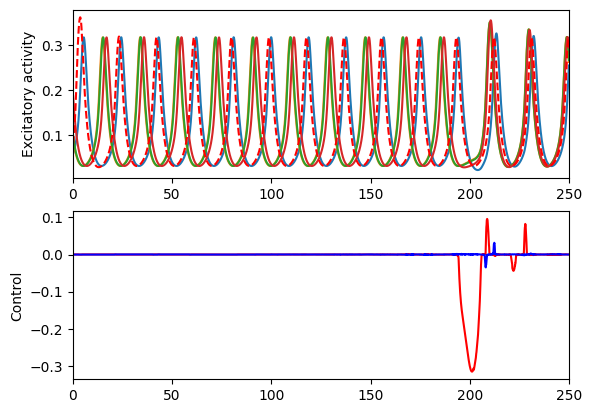

----------------- 195.0
Compute control for a noisy system
Mean cost in iteration 0: 0.9921188987762912
Mean cost in iteration 25: 1.055714962686531
Mean cost in iteration 50: 0.940671455128293
Mean cost in iteration 75: 0.9194602304690804
Mean cost in iteration 100: 0.8740368769099582
Mean cost in iteration 125: 0.9072685647339368
Mean cost in iteration 150: 0.9370009676121726
Mean cost in iteration 175: 0.9084466686342308
Mean cost in iteration 200: 0.7552697645489873
Mean cost in iteration 225: 0.7570987679262541
Mean cost in iteration 250: 0.706030608603443
Mean cost in iteration 275: 0.6906045233603945
Mean cost in iteration 300: 0.6574652833985691
Mean cost in iteration 325: 0.6161241509834638
Mean cost in iteration 350: 0.6327077825275746
Mean cost in iteration 375: 0.6116978469823633
Mean cost in iteration 400: 0.633177999799551
Mean cost in iteration 425: 0.5674271936627666
Mean cost in iteration 450: 0.6256314332109769
Mean cost in iteration 475: 0.5790692713241363
Mean cost 

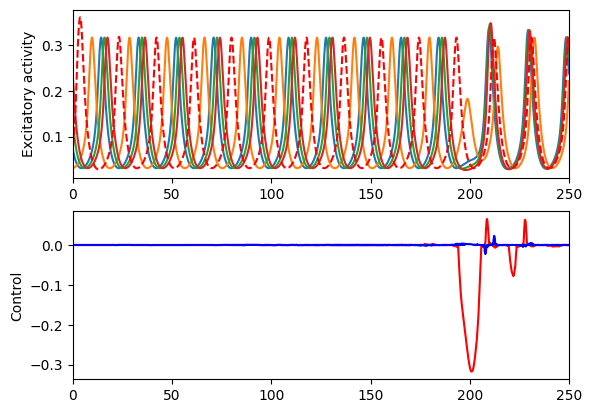

----------------- 200.0
Compute control for a noisy system
Mean cost in iteration 0: 0.8229055964200711
Mean cost in iteration 25: 0.9306667116401375
Mean cost in iteration 50: 0.8251961656149371
Mean cost in iteration 75: 0.8977401399128784
Mean cost in iteration 100: 0.8266635357419009
Mean cost in iteration 125: 0.8814681158632978
Mean cost in iteration 150: 0.8352277914385665
Mean cost in iteration 175: 0.7890846656423562
Mean cost in iteration 200: 0.7720413608532544
Mean cost in iteration 225: 0.8351204639040695
Mean cost in iteration 250: 0.729606860980101
Mean cost in iteration 275: 0.7741252510510276
Mean cost in iteration 300: 0.7512333527962002
Mean cost in iteration 325: 0.6983803197709106
Mean cost in iteration 350: 0.6436016100762993
Mean cost in iteration 375: 0.6297720462114341
Mean cost in iteration 400: 0.5606735598991172
Mean cost in iteration 425: 0.6340321053766331
Mean cost in iteration 450: 0.6523550261601605
Mean cost in iteration 475: 0.5349329670425573
Mean co

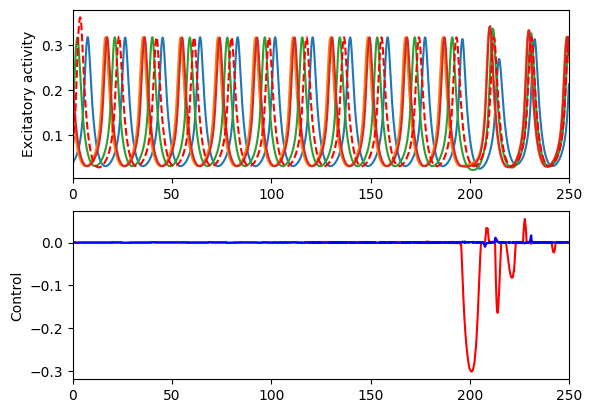

In [7]:
w1=1e-1
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1=w1, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w1_-1_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, fname)

In [ ]:
w1T=1e-2
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1T=w1T, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w1T_-2_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, fname)

In [ ]:
w1T=1e-1
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1T=w1T, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w1T_-1_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, fname)

In [ ]:
w1D=1e-1
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1D=w1D, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w1D_-1_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, fname)

In [ ]:
w1D=1e-2
M_ = 80

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=0., w_1D=w1D, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), M=M_, M_validation=400, random_init=init_ellipse)
    model_controlled.optimize(600)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w1D_-2_" + str(int(int0/10)) + ".png"

    plot_random_init(model_controlled.model.t, states, target_osc, control, fname)